'''

@Author: Jayesh Patil

@Date: 15-11-24

@Title: KNN to predict subscription to term deposite

'''

1.Based on bank customer data, predicted whether cutomer will subscribe to term deposit or not.

Importing Libraries

In [33]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy import stats


Loading Dataset

In [34]:
df = pd.read_csv('bank.csv',sep=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


Analysing Dataset

In [35]:
print(df.describe())
print(df.info())
print(df.shape)

               age       balance          day     duration     campaign  \
count  4521.000000   4521.000000  4521.000000  4521.000000  4521.000000   
mean     41.170095   1422.657819    15.915284   263.961292     2.793630   
std      10.576211   3009.638142     8.247667   259.856633     3.109807   
min      19.000000  -3313.000000     1.000000     4.000000     1.000000   
25%      33.000000     69.000000     9.000000   104.000000     1.000000   
50%      39.000000    444.000000    16.000000   185.000000     2.000000   
75%      49.000000   1480.000000    21.000000   329.000000     3.000000   
max      87.000000  71188.000000    31.000000  3025.000000    50.000000   

             pdays     previous  
count  4521.000000  4521.000000  
mean     39.766645     0.542579  
std     100.121124     1.693562  
min      -1.000000     0.000000  
25%      -1.000000     0.000000  
50%      -1.000000     0.000000  
75%      -1.000000     0.000000  
max     871.000000    25.000000  
<class 'pandas.cor

Handle missing data

In [36]:
print("Null Values ",df.isnull().sum())

Null Values  age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


Plot Outliers

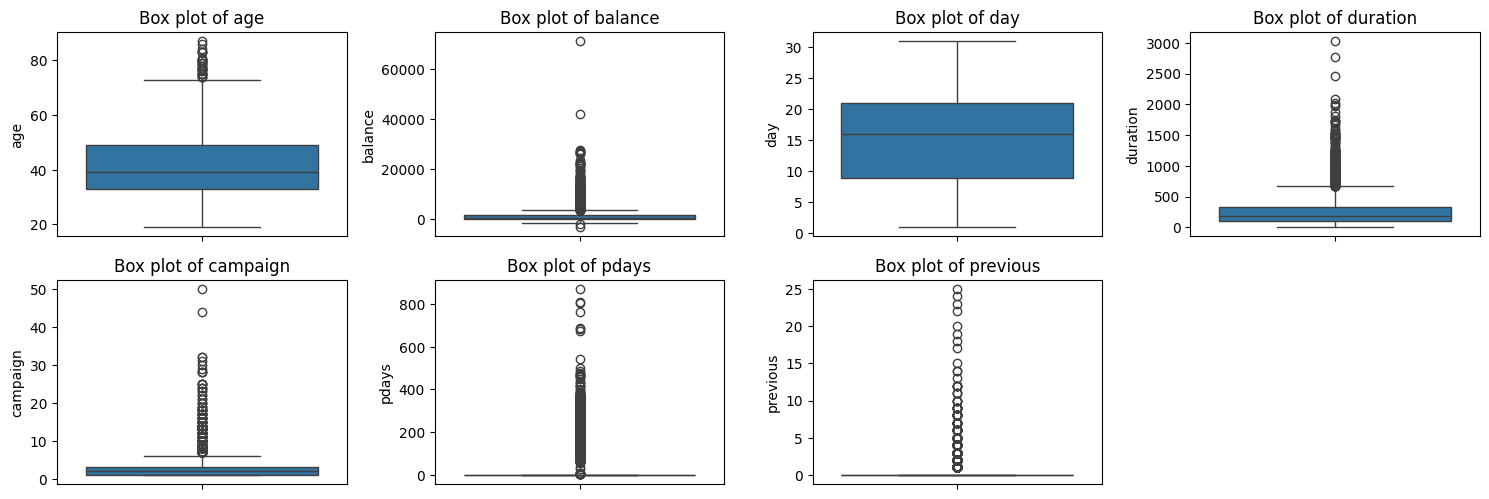

In [37]:
num_columns = df.select_dtypes(include=[np.number]).columns.tolist()
plt.figure(figsize=(15,10))
for i , column in enumerate(num_columns):
    plt.subplot(4,4,i+1)
    sns.boxplot(y=df[column])
    plt.title(f'Box plot of {column}')
plt.tight_layout()
plt.show()

Handeling outliers

In [38]:
Q1 = df[num_columns].quantile(0.25)
Q3 = df[num_columns].quantile(0.75)
IQR = Q3 - Q1
lower_bond = Q1 - 1.5 * IQR
upper_bond = Q3 + 1.5 * IQR
df_filtered = df[~((df[num_columns] < lower_bond) | (df[num_columns] > upper_bond)).any(axis=1)]
print(f'Original data shape: {df.shape}')
print(f'Filtered data shape(using IQR): {df_filtered.shape}')


Original data shape: (4521, 17)
Filtered data shape(using IQR): (2803, 17)


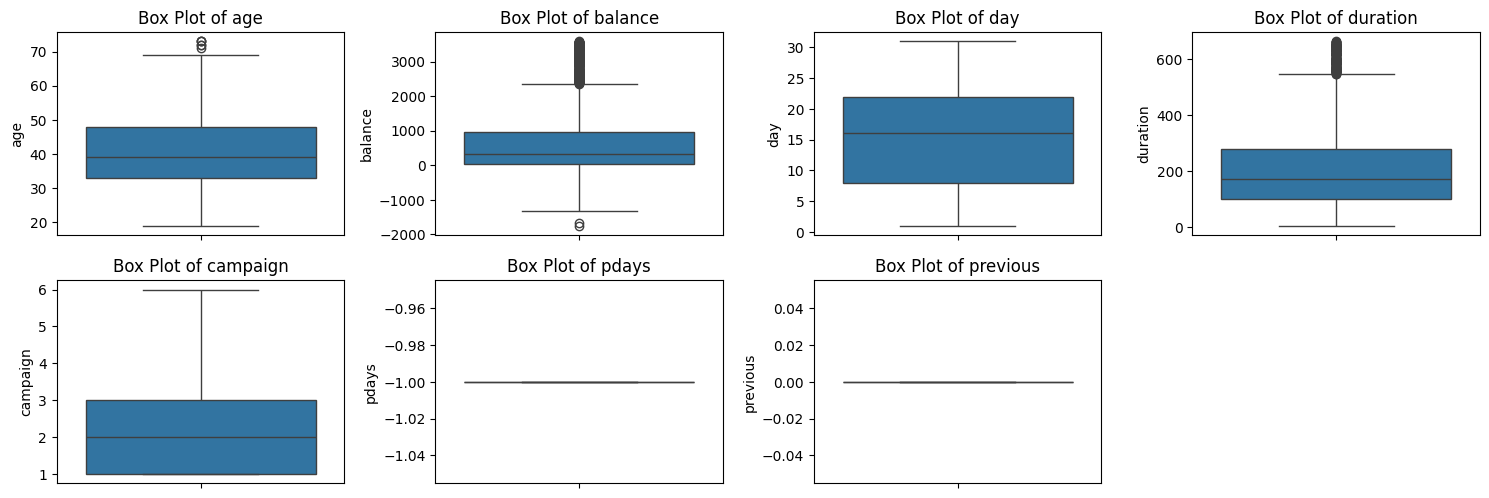

In [39]:
# Select only numerical columns
num_columns = df_filtered.select_dtypes(include=[np.number]).columns.tolist()

# Visualizing the initial data with box plots to check for outliers
plt.figure(figsize=(15, 10))
for i, column in enumerate(num_columns):
    plt.subplot(4, 4, i + 1)
    sns.boxplot(y=df_filtered[column])
    plt.title(f'Box Plot of {column}')
plt.tight_layout()
plt.show()

Handling Catogrial data

In [40]:
label_encoders = {}
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
for column in categorical_columns:
    le = LabelEncoder()
    df_filtered.loc[:, column] = le.fit_transform(df_filtered[column])
    label_encoders[column] = le
print(df_filtered)


      age job marital education default  balance housing loan contact  day  \
0      30  10       1         0       0     1787       0    0       0   19   
3      30   4       1         2       0     1476       1    1       2    3   
4      59   1       1         1       0        0       1    0       2    5   
7      39   9       1         1       0      147       1    0       0    6   
8      41   2       1         2       0      221       1    0       2   14   
...   ...  ..     ...       ...     ...      ...     ...  ...     ...  ...   
4510   36   9       0         1       0      566       1    0       2   20   
4512   40   1       1         1       0     1100       1    0       2   29   
4513   49   1       1         1       0      322       0    0       0   14   
4515   32   7       2         1       0      473       1    0       0    7   
4516   33   7       1         1       0     -333       1    0       0   30   

     month  duration  campaign  pdays  previous poutcome   y  


Feature Selecting

In [41]:
y = df_filtered['y'].map({'yes':1 ,'no':0})
x = df_filtered.drop(columns=['y'])

In [42]:
x

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,30,10,1,0,0,1787,0,0,0,19,10,79,1,-1,0,0
3,30,4,1,2,0,1476,1,1,2,3,6,199,4,-1,0,0
4,59,1,1,1,0,0,1,0,2,5,8,226,1,-1,0,0
7,39,9,1,1,0,147,1,0,0,6,8,151,2,-1,0,0
8,41,2,1,2,0,221,1,0,2,14,8,57,2,-1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4510,36,9,0,1,0,566,1,0,2,20,8,129,2,-1,0,0
4512,40,1,1,1,0,1100,1,0,2,29,8,660,2,-1,0,0
4513,49,1,1,1,0,322,0,0,0,14,1,356,2,-1,0,0
4515,32,7,2,1,0,473,1,0,0,7,5,624,5,-1,0,0


Plot Correlation

<function matplotlib.pyplot.show(close=None, block=None)>

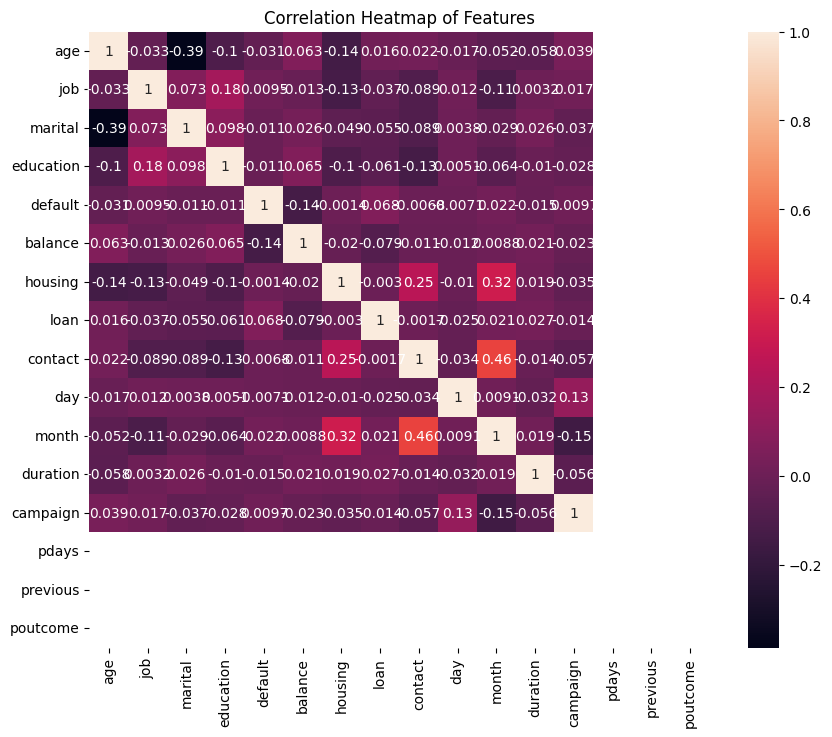

In [43]:
plt.figure(figsize=(10,8))
correlation_matrix = x.corr()
sns.heatmap(correlation_matrix, annot= True)
plt.title('Correlation Heatmap of Features')
plt.show

Scaling and spliting

In [44]:
X_train , X_test , y_train , y_test = train_test_split(x,y,test_size=0.2,random_state=42)
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.fit_transform(X_test)

Model Selection

In [45]:
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train_scaled,y_train)
y_pred = model.predict(X_test_scaled)

Model Performance

Accuracy: 0.9447415329768271
Confusion Matrix:
 [[530   3]
 [ 28   0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       533
           1       0.00      0.00      0.00        28

    accuracy                           0.94       561
   macro avg       0.47      0.50      0.49       561
weighted avg       0.90      0.94      0.92       561



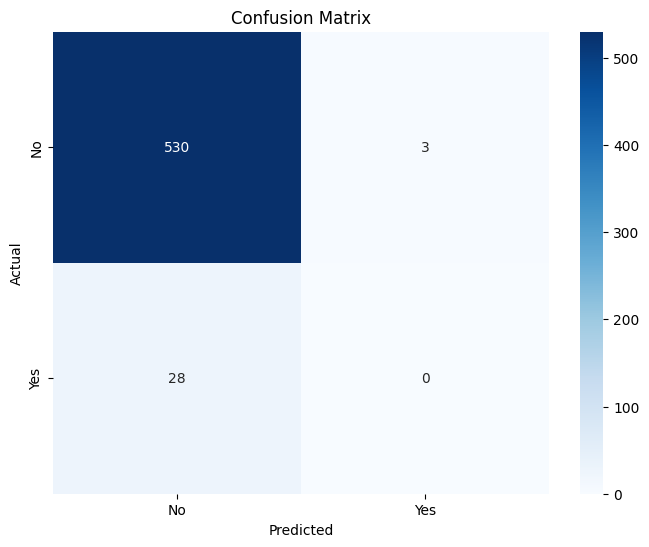

In [46]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:\n', conf_matrix)
print('Classification Report:\n', class_report)

# Visualizing the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()